<a href="https://colab.research.google.com/github/sofiaborgato/Homework2-Caltech101/blob/master/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import resnet18

from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url


In [0]:
#SET ARGUMENTS

DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 1000

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

ALPHA = 0.5


LOG_FREQUENCY = 10

In [0]:
#DEFINE DATA PREPROCESSING
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

In [4]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/sofiaborgato/Homework3-PACS.git
  


PHOTO_DIR = 'Homework3-PACS/PACS/photo'
CARTOON_DIR = 'Homework3-PACS/PACS/cartoon'
SKETCH_DIR = 'Homework3-PACS/PACS/sketch'
ART_DIR = 'Homework3-PACS/PACS/art_painting'
from torchvision.datasets import VisionDataset

# Prepare Pytorch train/test Datasets
photo = torchvision.datasets.ImageFolder(PHOTO_DIR, transform=train_transform)
cartoon = torchvision.datasets.ImageFolder(CARTOON_DIR, transform=eval_transform)
sketch =torchvision.datasets.ImageFolder(SKETCH_DIR, transform=eval_transform)
art =torchvision.datasets.ImageFolder(ART_DIR, transform=eval_transform)


# Check dataset sizes
print('Photo Dataset: {}'.format(len(photo)))
print('Art Painting Dataset: {}'.format(len(art)))
print('Cartoon Dataset: {}'.format(len(cartoon)))
print('Sketch Dataset: {}'.format(len(sketch)))

Photo Dataset: 1670
Art Painting Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photo_dataloader = DataLoader(photo, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
cartoon_dataloader = DataLoader(cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
art_dataloader = DataLoader(art, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
sketch_dataloader = DataLoader(sketch, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [0]:
import torch.nn as nn
from torch.autograd import Function

''' 
Very easy template to start for developing your AlexNet with DANN 
Has not been tested, might contain incompatibilities with most recent versions of PyTorch (you should address this)
However, the logic is consistent
'''
class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


In [0]:
#from functions import ReverseLayerF
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            
        )
        self.GDclassifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            
        )

    

    def forward(self, x, ALPHA=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        if ALPHA is not None:
            reverse_feature = ReverseLayerF.apply(x, ALPHA)
            discriminator_output = self.GDclassifier(reverse_feature)
            return discriminator_output
        else:
            class_outputs = self.classifier(x)
            return class_outputs


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)

    return model

In [0]:
net = alexnet(pretrained = True) # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, 7)
net.GDclassifier[6]= nn.Linear(4096,2)

net.GDclassifier[1].weight.data = net.classifier[1].weight.data
net.GDclassifier[1].bias.data = net.classifier[1].bias.data

net.GDclassifier[4].weight.data = net.classifier[4].weight.data
net.GDclassifier[4].bias.data = net.classifier[4].bias.data

net.GDclassifier[6].weight.data = net.classifier[6].weight.data
net.GDclassifier[6].bias.data = net.classifier[6].bias.data

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Actual parameters: Learning Rate = 0.000010, num_epochs = 10
Starting epoch 1/10, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.2963573932647705


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.14278442351743445
Starting epoch 2/10, LR = [1e-05]


Step 10, Loss 2.2020785808563232


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.14278442351743445
Starting epoch 3/10, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.14329345889539322
Starting epoch 4/10, LR = [1e-05]


Step 20, Loss 1.9686955213546753


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.1420208704504963
Starting epoch 5/10, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.14100279969457877
Starting epoch 6/10, LR = [1e-05]


Step 30, Loss 1.7718603610992432


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.14100279969457877
Starting epoch 7/10, LR = [1e-05]


Step 40, Loss 1.5783568620681763


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.1374395520488674
Starting epoch 8/10, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.13973021124968185
Starting epoch 9/10, LR = [1e-05]


Step 50, Loss 1.4379451274871826


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]

Validation Accuracy: 0.1341308220921354
Starting epoch 10/10, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Validation Accuracy: 0.1326037159582591


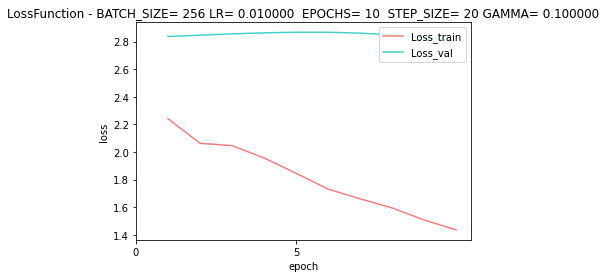

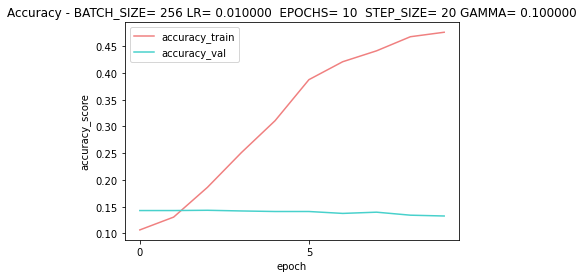

0.1326037159582591
Actual parameters: Learning Rate = 0.000010, num_epochs = 20
Starting epoch 1/20, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 1.8751163482666016


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.05446678544158819
Starting epoch 2/20, LR = [1e-05]


Step 10, Loss 1.8239949941635132


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.05446678544158819
Starting epoch 3/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.0542122677526088
Starting epoch 4/20, LR = [1e-05]


Step 20, Loss 1.6657142639160156


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.056248409264443876
Starting epoch 5/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.056502926953423266
Starting epoch 6/20, LR = [1e-05]


Step 30, Loss 1.5197714567184448


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.05930262153219649
Starting epoch 7/20, LR = [1e-05]


Step 40, Loss 1.4496102333068848


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.06108424535505218
Starting epoch 8/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.06490201068974294
Starting epoch 9/20, LR = [1e-05]


Step 50, Loss 1.3375779390335083


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.06642911682361924
Starting epoch 10/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.06821074064647493
Starting epoch 11/20, LR = [1e-05]


Step 60, Loss 1.2235251665115356


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]

Validation Accuracy: 0.07050139984728938
Starting epoch 12/20, LR = [1e-05]


Step 70, Loss 1.2198033332824707


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]

Validation Accuracy: 0.07279205904810385
Starting epoch 13/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.0750827182489183
Starting epoch 14/20, LR = [1e-05]


Step 80, Loss 1.236201286315918


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]

Validation Accuracy: 0.07711885976075337
Starting epoch 15/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.07890048358360906
Starting epoch 16/20, LR = [1e-05]


Step 90, Loss 1.0748425722122192


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]

Validation Accuracy: 0.08042758971748537
Starting epoch 17/20, LR = [1e-05]


Step 100, Loss 0.9899368286132812


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.08195469585136167
Starting epoch 18/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.08679053194196996
Starting epoch 19/20, LR = [1e-05]


Step 110, Loss 1.059800624847412


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.09442606261135149
Starting epoch 20/20, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


Validation Accuracy: 0.09824382794604225


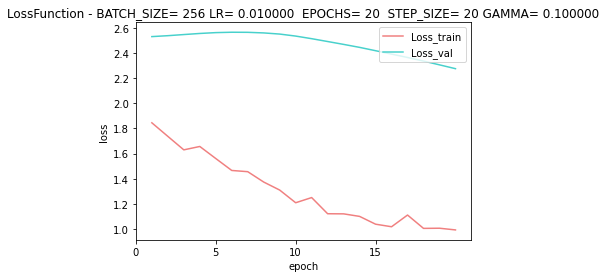

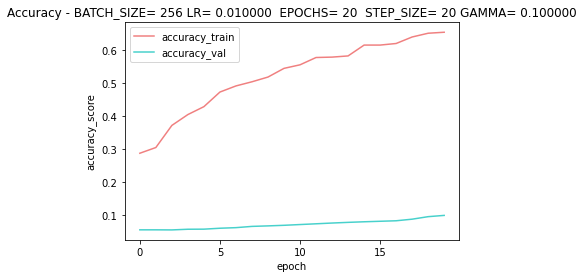

0.09824382794604225
Actual parameters: Learning Rate = 0.000010, num_epochs = 30
Starting epoch 1/30, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.1326723098754883


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.1885976075337236
Starting epoch 2/30, LR = [1e-05]


Step 10, Loss 1.9319689273834229


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.19114278442351743
Starting epoch 3/30, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1934334436243319
Starting epoch 4/30, LR = [1e-05]


Step 20, Loss 1.778761625289917


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.19699669127004327
Starting epoch 5/30, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.20055993891575463
Starting epoch 6/30, LR = [1e-05]


Step 30, Loss 1.6404443979263306


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.20208704504963096
Starting epoch 7/30, LR = [1e-05]


Step 40, Loss 1.5400736331939697


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.20335963349452787
Starting epoch 8/30, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.20514125731738356
Starting epoch 9/30, LR = [1e-05]


Step 50, Loss 1.3534672260284424


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.2061593280733011
Starting epoch 10/30, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Validation Accuracy: 0.20794095189615677
Starting epoch 11/30, LR = [1e-05]


Step 60, Loss 1.3068201541900635


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

Validation Accuracy: 0.20819546958513616
Starting epoch 12/30, LR = [1e-05]


Step 70, Loss 1.1598553657531738


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.20539577500636294
Starting epoch 13/30, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

Validation Accuracy: 0.20335963349452787
Starting epoch 14/30, LR = [1e-05]


Step 80, Loss 1.1185812950134277


100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

Validation Accuracy: 0.2015780096716722
Starting epoch 15/30, LR = [1e-05]



100%|██████████| 16/16 [00:13<00:00,  1.19it/s]

Validation Accuracy: 0.20005090353779587
Starting epoch 16/30, LR = [1e-05]


Step 90, Loss 1.0934150218963623


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.19725120895902265
Starting epoch 17/30, LR = [1e-05]


Step 100, Loss 1.0826131105422974


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]

Validation Accuracy: 0.19546958513616697
Starting epoch 18/30, LR = [1e-05]



100%|██████████| 16/16 [00:13<00:00,  1.23it/s]

Validation Accuracy: 0.19394247900229067
Starting epoch 19/30, LR = [1e-05]


Step 110, Loss 0.9982153177261353


100%|██████████| 16/16 [00:13<00:00,  1.23it/s]

Validation Accuracy: 0.19419699669127005
Starting epoch 20/30, LR = [1e-05]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.19394247900229067
Starting epoch 21/30, LR = [1.0000000000000002e-07]


Step 120, Loss 1.016245722770691


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.19394247900229067
Starting epoch 22/30, LR = [1.0000000000000002e-06]


Step 130, Loss 0.9770753383636475


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.19368796131331129
Starting epoch 23/30, LR = [1.0000000000000002e-06]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.19368796131331129
Starting epoch 24/30, LR = [1.0000000000000002e-06]


Step 140, Loss 1.0892375707626343


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.19368796131331129
Starting epoch 25/30, LR = [1.0000000000000002e-06]



100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.19368796131331129
Starting epoch 26/30, LR = [1.0000000000000002e-06]


Step 150, Loss 0.9306308031082153


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.19368796131331129
Starting epoch 27/30, LR = [1.0000000000000002e-06]


Step 160, Loss 1.043823480606079


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1934334436243319
Starting epoch 28/30, LR = [1.0000000000000002e-06]



100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Validation Accuracy: 0.1934334436243319
Starting epoch 29/30, LR = [1.0000000000000002e-06]


Step 170, Loss 1.0685151815414429


100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

Validation Accuracy: 0.19317892593535252
Starting epoch 30/30, LR = [1.0000000000000002e-06]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Validation Accuracy: 0.19292440824637314


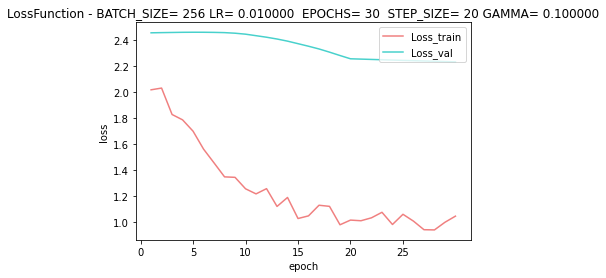

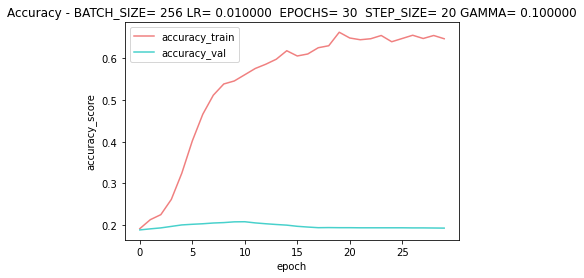

0.19292440824637314
Actual parameters: Learning Rate = 0.010000, num_epochs = 10
Starting epoch 1/10, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.070768117904663


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.19750572664800203
Starting epoch 2/10, LR = [0.01]


Step 10, Loss 0.7209479808807373


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 3/10, LR = [0.01]



100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Validation Accuracy: 0.21659455332145583
Starting epoch 4/10, LR = [0.01]


Step 20, Loss 0.35846811532974243


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 5/10, LR = [0.01]



100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 6/10, LR = [0.01]


Step 30, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 7/10, LR = [0.01]


Step 40, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 8/10, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 9/10, LR = [0.01]


Step 50, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 10/10, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Validation Accuracy: 0.1964876558920845


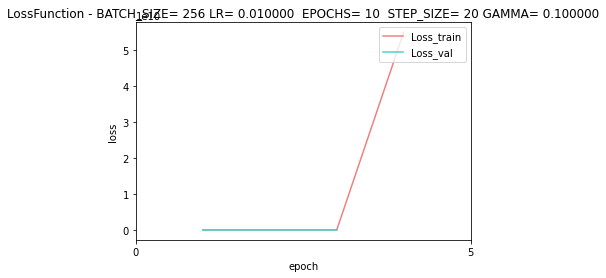

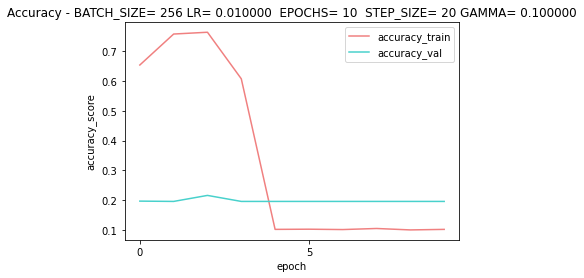

0.1964876558920845
Actual parameters: Learning Rate = 0.010000, num_epochs = 20
Starting epoch 1/20, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.409168004989624


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.2076864342071774
Starting epoch 2/20, LR = [0.01]


Step 10, Loss 0.8803988695144653


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.2076864342071774
Starting epoch 3/20, LR = [0.01]



100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

Validation Accuracy: 0.20666836345125986
Starting epoch 4/20, LR = [0.01]


Step 20, Loss 0.4094826281070709


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]

Validation Accuracy: 0.20692288114023924
Starting epoch 5/20, LR = [0.01]



100%|██████████| 16/16 [00:13<00:00,  1.19it/s]

Validation Accuracy: 0.20641384576228047
Starting epoch 6/20, LR = [0.01]


Step 30, Loss 0.20006579160690308


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.020361415118350726
Starting epoch 7/20, LR = [0.01]


Step 40, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 8/20, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 9/20, LR = [0.01]


Step 50, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 10/20, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 11/20, LR = [0.01]


Step 60, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 12/20, LR = [0.01]


Step 70, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 13/20, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 14/20, LR = [0.01]


Step 80, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 15/20, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 16/20, LR = [0.01]


Step 90, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 17/20, LR = [0.01]


Step 100, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 18/20, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 19/20, LR = [0.01]


Step 110, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 20/20, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Validation Accuracy: 0.1964876558920845


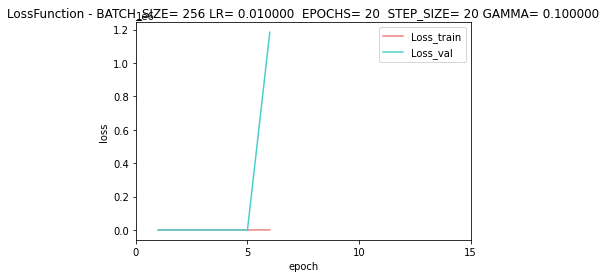

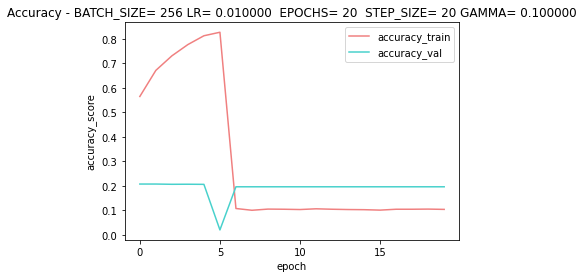

0.1964876558920845
Actual parameters: Learning Rate = 0.010000, num_epochs = 30
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 1.933496356010437


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.2076864342071774
Starting epoch 2/30, LR = [0.01]


Step 10, Loss 0.6603396534919739


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 3/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.2059048103843217
Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.3810722529888153


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.22015780096716722
Starting epoch 5/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 6/30, LR = [0.01]


Step 30, Loss 1710.245361328125


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 7/30, LR = [0.01]


Step 40, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 8/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 9/30, LR = [0.01]


Step 50, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 10/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 11/30, LR = [0.01]


Step 60, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 12/30, LR = [0.01]


Step 70, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 13/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 14/30, LR = [0.01]


Step 80, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 15/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 16/30, LR = [0.01]


Step 90, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 17/30, LR = [0.01]


Step 100, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 18/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 19/30, LR = [0.01]


Step 110, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 20/30, LR = [0.01]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 21/30, LR = [0.0001]


Step 120, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 22/30, LR = [0.001]


Step 130, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 23/30, LR = [0.001]



100%|██████████| 16/16 [00:13<00:00,  1.19it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 24/30, LR = [0.001]


Step 140, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 25/30, LR = [0.001]



100%|██████████| 16/16 [00:13<00:00,  1.23it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 26/30, LR = [0.001]


Step 150, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 27/30, LR = [0.001]


Step 160, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 28/30, LR = [0.001]



100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 29/30, LR = [0.001]


Step 170, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 30/30, LR = [0.001]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Validation Accuracy: 0.1964876558920845


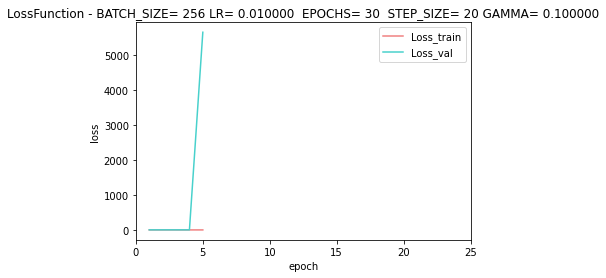

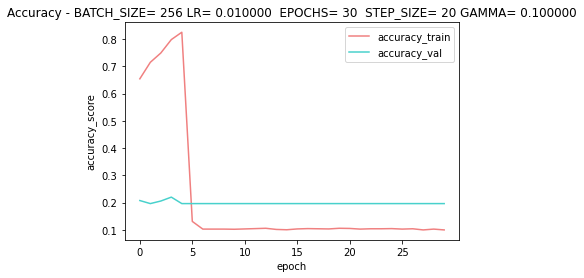

0.1964876558920845
Actual parameters: Learning Rate = 0.100000, num_epochs = 10
Starting epoch 1/10, LR = [0.1]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 1.9972703456878662


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 2/10, LR = [0.1]


Step 10, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 3/10, LR = [0.1]



100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 4/10, LR = [0.1]


Step 20, Loss nan


100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 5/10, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.23it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 6/10, LR = [0.1]


Step 30, Loss nan


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 7/10, LR = [0.1]


Step 40, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.16it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 8/10, LR = [0.1]



100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

Validation Accuracy: 0.1964876558920845
Starting epoch 9/10, LR = [0.1]


Step 50, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 10/10, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Validation Accuracy: 0.1964876558920845


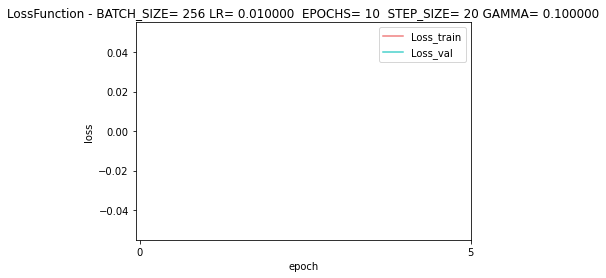

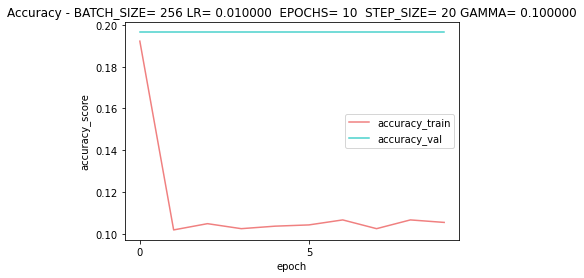

0.1964876558920845
Actual parameters: Learning Rate = 0.100000, num_epochs = 20
Starting epoch 1/20, LR = [0.1]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 1.9783775806427002


100%|██████████| 16/16 [00:12<00:00,  1.23it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 2/20, LR = [0.1]


Step 10, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 3/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 4/20, LR = [0.1]


Step 20, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 5/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 6/20, LR = [0.1]


Step 30, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 7/20, LR = [0.1]


Step 40, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 8/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 9/20, LR = [0.1]


Step 50, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 10/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 11/20, LR = [0.1]


Step 60, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 12/20, LR = [0.1]


Step 70, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 13/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 14/20, LR = [0.1]


Step 80, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.23it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 15/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 16/20, LR = [0.1]


Step 90, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 17/20, LR = [0.1]


Step 100, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 18/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 19/20, LR = [0.1]


Step 110, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 20/20, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Validation Accuracy: 0.1964876558920845


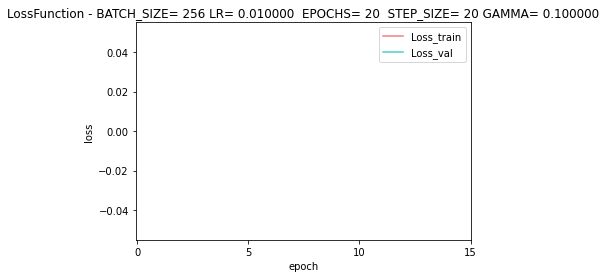

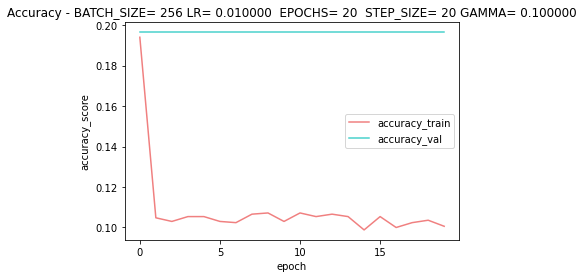

0.1964876558920845
Actual parameters: Learning Rate = 0.100000, num_epochs = 30
Starting epoch 1/30, LR = [0.1]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.184583902359009


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 2/30, LR = [0.1]


Step 10, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 3/30, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 4/30, LR = [0.1]


Step 20, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 5/30, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 6/30, LR = [0.1]


Step 30, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 7/30, LR = [0.1]


Step 40, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 8/30, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 9/30, LR = [0.1]


Step 50, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 10/30, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 11/30, LR = [0.1]


Step 60, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 12/30, LR = [0.1]


Step 70, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 13/30, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 14/30, LR = [0.1]


Step 80, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 15/30, LR = [0.1]



100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 16/30, LR = [0.1]


Step 90, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 17/30, LR = [0.1]


Step 100, Loss nan


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 18/30, LR = [0.1]



100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 19/30, LR = [0.1]


Step 110, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 20/30, LR = [0.1]



100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 21/30, LR = [0.0010000000000000002]


Step 120, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 22/30, LR = [0.010000000000000002]


Step 130, Loss nan


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 23/30, LR = [0.010000000000000002]



100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 24/30, LR = [0.010000000000000002]


Step 140, Loss nan


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 25/30, LR = [0.010000000000000002]



100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 26/30, LR = [0.010000000000000002]


Step 150, Loss nan


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 27/30, LR = [0.010000000000000002]


Step 160, Loss nan


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 28/30, LR = [0.010000000000000002]



100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

Validation Accuracy: 0.1964876558920845
Starting epoch 29/30, LR = [0.010000000000000002]



Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff19612d080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


RuntimeError: ignored

In [10]:
#TRAIN WITH VALIDATION

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime
learning_rate_vector = [1e-5,1e-2,1e-1]
alpha_vector  = [0.001, 0.05, 0.1]
num_epochs_vector = [10, 20, 30]

m_acc_val1=np.empty((len(learning_rate_vector),len(alpha_vector)))
m_acc_val2=np.empty((len(learning_rate_vector),len(alpha_vector)))
i=0


for l in learning_rate_vector:
  j=0
  for num in num_epochs_vector:
    best_accuracy=0
    vett_loss = []
    vett_loss_discr = []
    vett_loss_discr_test = []
    loss_test=[]
    loss_vector=[]
    acc_train=[]
    loss_val=[]
    current_step = 0
    best_accuracy = 0
    loss_train=[]
    tot_accuracy = []
    vett_loss_discr=[]
    net=alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, 7)
    NUM_EPOCHS = num
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    cudnn.benchmark # Calling this optimizes runtime
    print("Actual parameters: Learning Rate = %f, num_epochs = %d" %(l,num))
    current_step = 0
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

      # Iterate over the dataset
      running_correct_train=0
      for images, labels in photo_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train() # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients
        #3B1 Forward pass to the classifier
        outputs = net(images)
        #3b1compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # backward pass: computes gradients
        loss_train.append(loss)
        
        #calculte accuracy also on train set
        _, preds = torch.max(outputs.data, 1)
        running_correct_train += torch.sum(preds == labels.data).data.item()
        #3B.2 Forward pass to the discriminator
        discriminator_output = net.forward(images,ALPHA)
        targets = torch.zeros(labels.size(0),dtype=torch.int64).to(DEVICE)
        loss_discriminator = criterion(discriminator_output,targets)
        loss_discriminator.backward()
        #3B.3 Forward pass to the discriminator with Cartoon
        test_images, test_labels = next(iter(sketch_dataloader))
        test_images = test_images.to(DEVICE)
        test_labels = test_labels.to(DEVICE)

        discriminator_output_test = net(test_images,ALPHA)
        targets = torch.ones(labels.size(0),dtype=torch.int64).to(DEVICE)
        loss_discriminator_test = criterion(discriminator_output_test,targets)
        loss_discriminator_test.backward()
        vett_loss_discr.append(loss_discriminator)
        vett_loss_discr_test.append(loss_discriminator_test)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))

        
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1
      
      loss_vector.append(loss.item())
      acc_t=running_correct_train / float(len(photo))
      acc_train.append(acc_t)
      # Step the scheduler
      scheduler.step()

      #VALIDATION
      net=net.to(DEVICE)
      net.train(False) # Set Network to evaluation mode
      

      running_corrects = 0
      with torch.no_grad():
          for images, labels in tqdm(sketch_dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()
      # Calculate Accuracy
      accuracy = running_corrects / float(len(sketch))
      #loss on validation
      loss_val.append(criterion(outputs,labels))
      tot_accuracy.append(accuracy)
      print('Validation Accuracy: {}'.format(accuracy))
    tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
    x=np.linspace(1,num,num)
    punti=np.arange(0,num,5)
    plt.plot(x,loss_vector,color='lightcoral')
    plt.plot(x,loss_val,color='mediumturquoise')
    plt.xticks(punti)
    plt.title(tit)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Loss_train','Loss_val'],loc='upper right')
    plt.show()
    tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
    plt.plot(acc_train,color='lightcoral')
    plt.plot(tot_accuracy,color='mediumturquoise')
    plt.legend(['accuracy_train','accuracy_val'],loc='best')
    plt.title(tit_2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy_score')
    plt.xticks(punti)
    plt.show()
    
    
    if accuracy>best_accuracy:
      best_net = copy.deepcopy(net)
      best_accuracy=accuracy
    print(best_accuracy)

In [0]:
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,30,30)
#punti=[1,4,8,12,16,20,24]
plt.plot(x,loss_vector,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')
#plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_val'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.legend(['accuracy_train','accuracy_val'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
#plt.xticks(punti)
#print(acc_train)
print(best_accuracy)

In [0]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime

loss_val=[]

acc_train=[]
current_step = 0
best_accuracy = 0
loss_vector = []
tot_accuracy = []
current_step=0
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  running_correct_train=0
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    #calculte accuracy also on train set
    _, preds = torch.max(outputs.data, 1)
    running_correct_train += torch.sum(preds == labels.data).data.item()
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  loss_vector.append(loss.item())
  acc_t=running_correct_train / float(len(val_dataset))
  acc_train.append(acc_t)
  # Step the scheduler
  scheduler.step()

  #VALIDATION
  net.train(False) # Set Network to evaluation mode
  

  running_corrects = 0
  with torch.no_grad():
      for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  #loss on validation
  loss_val.append(criterion(outputs,labels))
  tot_accuracy.append(accuracy)
  print('Validation Accuracy: {}'.format(accuracy))

  if accuracy>best_accuracy:
    best_net = copy.deepcopy(net)
    best_accuracy=accuracy